In [68]:
import abc
import numpy as np
import jax.numpy as jnp
from jax import jacfwd, hessian, jit
from manifpy import SE3, SE3Tangent, SO3, SO3Tangent
from scipy.linalg import logm
import scipy

# Test: skew, unskew, se3 representation transform, adjoint

In [88]:
def skew( w ):
    """Get the isomorphic element in the Lie algebra for SO3, 
        i.e. the skew symmetric matrix."""
    if isinstance(w, np.ndarray) or isinstance(w, jnp.ndarray) and w.shape == (3,) or w.shape == (3, 1):
        w = w.reshape(-1)
        return np.array([
            [0, -w[2], w[1]],
            [w[2], 0, -w[0]],
            [-w[1], w[0], 0]
        ])
    else:
        raise ValueError("Input must be a 3d vector")


a = np.array([[0.],
 [0.],
 [0.]])
print(skew(a))

w = np.array([1., 2., 3.])
print(skew(w))

[[ 0. -0.  0.]
 [ 0.  0. -0.]
 [-0.  0.  0.]]
[[ 0. -3.  2.]
 [ 3.  0. -1.]
 [-2.  1.  0.]]


In [10]:
def skew( w ):
    return SO3Tangent(w).hat()

w = np.array([1, 2, 3])
print(skew(w))

[[ 0. -3.  2.]
 [ 3.  0. -1.]
 [-2.  1.  0.]]


In [11]:
def adjoint(x):
    w = np.array([x[0], x[1], x[2]])
    v = np.array([x[3], x[4], x[5]])
    adx = np.block([
        [skew(w), np.zeros((3, 3))],
        [skew(v), skew(w)]
    ])
    return adx

x = [1, 2, 3, 4, 5, 6]
result = adjoint(x)
print(result)

[[ 0. -3.  2.  0.  0.  0.]
 [ 3.  0. -1.  0.  0.  0.]
 [-2.  1.  0.  0.  0.  0.]
 [ 0. -6.  5.  0. -3.  2.]
 [ 6.  0. -4.  3.  0. -1.]
 [-5.  4.  0. -2.  1.  0.]]


In [92]:
def unskew(omega_hat):
    """
    Extract the vector from a 3x3 skew-symmetric matrix.
    
    Parameters:
    omega_hat (numpy.ndarray): 3x3 skew-symmetric matrix
    
    Returns:
    numpy.ndarray: 3x1 vector corresponding to the skew-symmetric matrix
    """
    
    if isinstance(omega_hat, np.ndarray) or isinstance(omega_hat, jnp.ndarray) \
        and omega_hat.shape == (3,3):
        return np.array([omega_hat[2, 1], omega_hat[0, 2], omega_hat[1, 0]])
    else:
        raise ValueError("Input must be a 3d vector")
    

a = np.array([
    [0,1,1],
    [-1,0,1],
    [-1,-1,0]
])
unskew(a)


array([-1,  1, -1])

In [ ]:
from scipy.linalg import expm, logm
# from scipy.spatial.transform import Rotation as R
from pyquaternion import Quaternion

q0_ref = np.array([1, 0, 0, 0])
p0_ref = np.array([0, 0, 0])
w0_ref = np.array([0, 0, 1]) * 1
v0_ref = np.array([1, 0, 0.1]) * 2

# x0_ref and X should be kept the same
x0_ref = np.concatenate((q0_ref, p0_ref))
# X = np.eye(4) # SE(3)
X = np.block([
    [ Quaternion(q0_ref).rotation_matrix, p0_ref.reshape(-1,1) ],
    [ np.zeros((1,3)),1 ],
])

logm(X)
rot_matrix = X[:3, :3]
position = X[:3, 3]

unskew(rot_matrix)

In [91]:
# Quaternion se3 vector representation to se3 matrix representation

q0_ref = np.array([1, 0, 0, 0])
p0_ref = np.array([0, 0, 0])
w0_ref = np.array([0, 0, 1]) * 1
v0_ref = np.array([1, 0, 0.1]) * 2

# x0_ref and X should be kept the same
x0_ref = np.concatenate((q0_ref, p0_ref))
# X = np.eye(4) # SE(3)
X = np.block([
    [ Quaternion(q0_ref).rotation_matrix, p0_ref.reshape(-1,1) ],
    [ np.zeros((1,3)),1 ],
])
X

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])

In [8]:
# check the Lie algebra of identity SE(3)
X0 = np.block([
    [np.identity(3), np.zeros((3,1))],
    [np.zeros((1,3)), 1]
])
logm(X0)

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [15]:
from pyquaternion import Quaternion
rot_matrix = jnp.array([[ 0.9992003 , -0.03998933,  0.        ],
            [ 0.03998934,  0.99920005,  0.        ],
            [ 0.        ,  0.        ,  1.        ]])
quaternion = Quaternion(matrix=rot_matrix)

ValueError: Matrix must be orthogonal, i.e. its transpose should be its inverse

# From other files

In [57]:
import abc
import numpy as np
import jax.numpy as jnp
from jax import jacfwd, hessian, jit
from manifpy import SE3, SE3Tangent, SO3, SO3Tangent

class BaseDynamics():

    """Dynamics Model."""

    @property
    @abc.abstractmethod
    def state_size(self):
        """State size."""
        raise NotImplementedError

    @property
    @abc.abstractmethod
    def action_size(self):
        """Action size."""
        raise NotImplementedError

    @property
    @abc.abstractmethod
    def has_hessians(self):
        """Whether the second order derivatives are available."""
        raise NotImplementedError

    @abc.abstractmethod
    def f(self, x, u, i):
        """Dynamics model.

        Args:
            x: Current state [state_size].
            u: Current control [action_size].
            i: Current time step.

        Returns:
            Next state [state_size].
        """
        raise NotImplementedError

    @abc.abstractmethod
    def f_x(self, x, u, i):
        """Partial derivative of dynamics model with respect to x.

        Args:
            x: Current state [state_size].
            u: Current control [action_size].
            i: Current time step.

        Returns:
            df/dx [state_size, state_size].
        """
        raise NotImplementedError

    @abc.abstractmethod
    def f_u(self, x, u, i):
        """Partial derivative of dynamics model with respect to u.

        Args:
            x: Current state [state_size].
            u: Current control [action_size].
            i: Current time step.

        Returns:
            df/du [state_size, action_size].
        """
        raise NotImplementedError

    @abc.abstractmethod
    def f_xx(self, x, u, i):
        """Second partial derivative of dynamics model with respect to x.

        Note:
            This is not necessary to implement if you're planning on skipping
            Hessian evaluation as the iLQR implementation does by default.

        Args:
            x: Current state [state_size].
            u: Current control [action_size].
            i: Current time step.

        Returns:
            d^2f/dx^2 [state_size, state_size, state_size].
        """
        raise NotImplementedError

    @abc.abstractmethod
    def f_ux(self, x, u, i):
        """Second partial derivative of dynamics model with respect to u and x.

        Note:
            This is not necessary to implement if you're planning on skipping
            Hessian evaluation as the iLQR implementation does by default.

        Args:
            x: Current state [state_size].
            u: Current control [action_size].
            i: Current time step.

        Returns:
            d^2f/dudx [state_size, action_size, state_size].
        """
        raise NotImplementedError

    @abc.abstractmethod
    def f_uu(self, x, u, i):
        """Second partial derivative of dynamics model with respect to u.

        Note:
            This is not necessary to implement if you're planning on skipping
            Hessian evaluation as the iLQR implementation does by default.

        Args:
            x: Current state [state_size].
            u: Current control [action_size].
            i: Current time step.

        Returns:
            d^2f/du^2 [state_size, action_size, action_size].
        """
        raise NotImplementedError
    

# Matrix: concatenate, Cholesky, block

In [81]:
A = np.random.rand(3,3)
x1 = np.random.rand(3,)
print(A @ x1)
print(A @ x1.reshape(3,1))

[0.18104214 0.27512016 0.34053364]
[[0.18104214]
 [0.27512016]
 [0.34053364]]


In [117]:
N = 100
A = np.random.rand(N,N)
A = A @ A.T
b = np.random.rand(N,)
b = np.identity(N)

In [128]:
%%time
np.linalg.inv( A )

CPU times: user 895 ms, sys: 17.8 ms, total: 912 ms
Wall time: 84.1 ms


array([[  803.68384231, -2827.6285509 ,  -627.15787174, ...,
         -884.31119431, -2381.63096804,   904.68559651],
       [-2827.62855093, 10049.34123242,  2199.80384512, ...,
         3197.19933464,  8450.81566609, -3255.67460139],
       [ -627.15787174,  2199.80384508,   495.60280518, ...,
          676.92422507,  1852.41841402,  -694.04911121],
       ...,
       [ -884.31119434,  3197.19933472,   676.92422511, ...,
         1064.37288361,  2688.1179983 , -1070.12262911],
       [-2381.63096806,  8450.81566609,  1852.41841406, ...,
         2688.11799823,  7115.46054215, -2738.49952392],
       [  904.68559654, -3255.67460146,  -694.04911124, ...,
        -1070.1226291 , -2738.49952398,  1084.9084987 ]])

In [133]:
%%time
L = np.linalg.cholesky(A)
Y = np.linalg.solve( L,b )
np.linalg.solve( L.T,Y )

CPU times: user 614 ms, sys: 0 ns, total: 614 ms
Wall time: 59 ms


array([[  803.68384279, -2827.6285526 ,  -627.15787211, ...,
         -884.31119486, -2381.63096947,   904.68559707],
       [-2827.6285526 , 10049.34123841,  2199.80384642, ...,
         3197.19933656,  8450.81567112, -3255.67460334],
       [ -627.15787211,  2199.80384642,   495.60280547, ...,
          676.92422551,  1852.41841515,  -694.04911165],
       ...,
       [ -884.31119486,  3197.19933656,   676.92422551, ...,
         1064.3728842 ,  2688.11799985, -1070.12262971],
       [-2381.63096947,  8450.81567112,  1852.41841515, ...,
         2688.11799985,  7115.46054638, -2738.49952556],
       [  904.68559707, -3255.67460334,  -694.04911165, ...,
        -1070.12262971, -2738.49952556,  1084.90849932]])

In [84]:
def is_pos_def(A):

    if np.array_equal(A, A.T):
        try:
            np.linalg.cholesky(A)
            return True
        except np.linalg.LinAlgError:
            return False
    else:
        return False

A = np.array([[0.00042   , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.00022408, 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.00014346, 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.00012   , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.00012   ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.00012   ]])
is_pos_def(A)

True

In [76]:
%%time
L = np.linalg.cholesky(A)

CPU times: user 56 µs, sys: 0 ns, total: 56 µs
Wall time: 75.6 µs


In [77]:
%%time
L = scipy.linalg.cholesky(A)

CPU times: user 874 µs, sys: 47 µs, total: 921 µs
Wall time: 1 ms


In [16]:
%%time
print( np.linalg.inv(A) )

[[  22.49354923  -12.09381747 -115.36702469   30.39007015   46.2033949
    55.03021345]
 [ -12.09381747    8.25726373   70.89058585  -19.01099151  -28.93531811
   -34.38692603]
 [-115.36702469   70.89058585  937.79759358 -267.71410929 -357.06033939
  -455.09988849]
 [  30.39007015  -19.01099151 -267.71410929   82.30050144   96.1712217
   131.5011256 ]
 [  46.2033949   -28.93531811 -357.06033939   96.1712217   143.33056057
   170.7229156 ]
 [  55.03021345  -34.38692603 -455.09988849  131.5011256   170.7229156
   223.08325225]]
CPU times: user 0 ns, sys: 599 µs, total: 599 µs
Wall time: 595 µs


In [17]:
a = np.random.rand(3,5)
b = np.random.rand(4,5)
print(np.block([
        [a],
        [b]
        ]))
print( np.vstack((a,b)) )

[[0.701338   0.90362319 0.35580253 0.43872471 0.33584242]
 [0.78572365 0.32627589 0.32677708 0.09971339 0.03051442]
 [0.62323308 0.12967421 0.7280731  0.19041106 0.61960876]
 [0.77806145 0.48085519 0.39829099 0.35475881 0.43044805]
 [0.21390172 0.21716325 0.79016275 0.02751951 0.36641839]
 [0.13051864 0.69473723 0.4296242  0.65784121 0.54592915]
 [0.51906555 0.01540421 0.26740032 0.53290973 0.50858944]]
[[0.701338   0.90362319 0.35580253 0.43872471 0.33584242]
 [0.78572365 0.32627589 0.32677708 0.09971339 0.03051442]
 [0.62323308 0.12967421 0.7280731  0.19041106 0.61960876]
 [0.77806145 0.48085519 0.39829099 0.35475881 0.43044805]
 [0.21390172 0.21716325 0.79016275 0.02751951 0.36641839]
 [0.13051864 0.69473723 0.4296242  0.65784121 0.54592915]
 [0.51906555 0.01540421 0.26740032 0.53290973 0.50858944]]


In [18]:
m = 1
Ib = np.diag([ 0.5,0.7,0.9 ])
J = np.block([
    [Ib, np.zeros((3, 3))],
    [np.zeros((3, 3)), m * np.identity(3)]
])
J

array([[0.5, 0. , 0. , 0. , 0. , 0. ],
       [0. , 0.7, 0. , 0. , 0. , 0. ],
       [0. , 0. , 0.9, 0. , 0. , 0. ],
       [0. , 0. , 0. , 1. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 1. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 1. ]])

In [10]:
a = np.ones((12,1))
b = np.ones((12,))
a + b

# Main issue of data shape mismatch:
# the result of (12,) tensor + (12,1) tensor is  (12,12) tensor

array([[2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
       [2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
       [2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
       [2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
       [2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
       [2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
       [2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
       [2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
       [2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
       [2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
       [2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
       [2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.]])

In [26]:
a = np.array([[0.00042   , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.00022408, 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.00014346, 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.00012   , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.00012   ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.00012   ]])

np.linalg.eigvals(a) > 0

array([ True,  True,  True,  True,  True,  True])

In [31]:
3.**(-np.arange(10)**2)

array([1.00000000e+00, 3.33333333e-01, 1.23456790e-02, 5.08052634e-05,
       2.32305731e-08, 1.18023539e-12, 6.66246331e-18, 4.17886671e-24,
       2.91232406e-31, 2.25516523e-39])

# Error-State SE(3) Dynamics

In [59]:
class ErrorStateSE3AutoDiffDynamics(BaseDynamics):

    """Error-State SE(3) Dynamics Model implemented with Jax for Derivatvies"""

    def __init__(self, J, X_ref, xi_ref, dt, integration_method="euler",
                    state_size=(6,6), action_size=6, hessians=False, **kwargs):
        """Constructs an Dynamics model for SE(3).

        Args:
            J: Inertia matrix, diag(I_b, m * I_3), 
                m : body mass,
                I_b : moment of inertia in the body frame.
            X_ref: List of Lie Group reference, (N, error_state_size, 1)
            xi_ref: List of velocity reference, described in Lie Algebra,
                 (N, velocity_size, 1)
            dt: Sampling time
            state_size: Tuple of State variable dimension, 
                ( error state size, velocity state size ).
            action_size: Input variable dimension.
            hessians: Evaluate the dynamic model's second order derivatives.
                Default: only use first order derivatives. (i.e. iLQR instead
                of DDP).
            **kwargs: Additional keyword-arguments to pass to any potential 
                function, e.g. in the preivious version `theano.function()`.
        """

        self._state_size = state_size[0] + state_size[1]
        self._error_state_size = state_size[0] 
        self._vel_state_size = state_size[1] 
        self._action_size = action_size

        self._X_ref = X_ref
        self._xi_ref = xi_ref
        self._x_ref = np.concatenate(( X_ref, xi_ref ), axis = 1)

        self._Ib = J[0:3, 0:3] 
        self._m = J[4,4]
        self._J = J
        self._Jinv = np.linalg.inv(J)
        
        if X_ref.shape[0] != xi_ref.shape[0]:
            raise ValueError("Group reference X and velocity reference should share the same time horizon")
        self._horizon = X_ref.shape[0]
        self._dt = dt

        self.integration_method = integration_method
        if integration_method == "euler":
            self.f = self.fd_euler
        elif integration_method == "rk4":
            self.f = self.fd_rk4
        else:
            raise ValueError("Invalid integration method. Choose 'euler' or 'rk4'.")
        
        self._f = jit(self.f)
        self._f_x = jit(jacfwd(self.f))
        self._f_u = jit(jacfwd(self.f, argnums=1))

        self._has_hessians = hessians
        if hessians:
            self._f_xx = jit(hessian(self.f, argnums=0))
            self._f_ux = jit(jacfwd( jacfwd(self.f, argnums=1) ))
            self._f_uu = jit(hessian(self.f, argnums=1))

        super(ErrorStateSE3AutoDiffDynamics, self).__init__()

    @property
    def state_size(self):
        """State size."""
        return self._state_size

    @property
    def error_state_size(self):
        """Error-state size."""
        return self._error_state_size

    @property
    def vel_state_size(self):
        """Velocity state size."""
        return self._vel_state_size

    @property
    def action_size(self):
        """Action size."""
        return self._action_size

    @property
    def has_hessians(self):
        """Whether the second order derivatives are available."""
        return self._has_hessians

    @property
    def Ib(self):
        """Moment of inertia in the body frame."""
        return self._Ib

    @property
    def m(self):
        """Mass of the system."""
        return self._Ib

    @property
    def J(self):
        """Inertia matrix of the system."""
        return self._J
    
    @property
    def Jinv(self):
        """Inverse of the inertia matrix."""
        return self._Jinv

    @property
    def horizon(self):
        """The horizon for dynamics to be valid, due to horizon of given reference."""
        return self._horizon
    
    @property
    def dt(self):
        """Sampling time of the system dynamics."""
        return self._dt

    def xi_ref(self, i) :
        """Return the Lie Algebra velocity xi reference xi_ref at time index i."""
        return self._xi_ref[i]

    def X_ref(self, i) :
        """Return the Lie group reference X_ref at time index i."""
        return self._X_ref[i]

    def x_ref(self, i) :
        """Return the concatenated Lie group and Lie algebra reference X_ref at time index i."""
        return self._x_ref[i]

    def adjoint( self, xi ):
        """ Get the the adjoint matrix representation of Lie Algebra."""
        w = np.array([xi[0], xi[1], xi[2]])
        v = np.array([xi[3], xi[4], xi[5]])
        adx = np.block([
            [skew(w), np.zeros((3, 3))],
            [skew(v), skew(w)]
        ])
        return adx
    
    def coadjoint( self, xi ):
        """ Get the the coadjoint matrix representation of Lie Algebra."""
        return self.adjoint(xi).T

    def fc(self, x, u, i):
        """ Continuous linearized dynamicsf.

        Args:
            x: Current state [state_size], stacked by
                error-state and velocity, both on Lie Algebra
            u: Current control [action_size].
            i: Current time step.

        Returns:
            Next state [state_size].
        """

        # psi = x[:self.error_state_size]
        xi = x[-self.vel_state_size:]
        omega = xi[:3]
        v = xi[-3:]

        # print("v is shape of \n", v.shape, "with value", v)

        G = np.block([
            [skew( self.Ib @ omega ), self.m * skew( v )],
            [self.m * skew( v ), np.zeros((3,3))],        
        ])
        Ht = - self.Jinv @ ( self.coadjoint( xi ) @ self.J + G )
        bt = - self.Jinv @ G @ xi

        # print("\nG is shape of", G.shape, "with value \n", G)
        # print("\nHt is shape of", Ht.shape, "with value \n", Ht)
        # print("\nbt is shape of", bt.shape, "with value \n", bt)

        At = np.block([
            [- self.adjoint( self.xi_ref(i) ), np.identity( self.error_state_size )],
            [np.zeros((self.vel_state_size, self.error_state_size)), Ht]
        ])
        Bt = np.vstack((np.zeros((self.error_state_size, self.action_size)),
                self.Jinv ))
        ht = np.vstack( (-self.xi_ref(i), bt ))

        # print("\nAt is shape of", At.shape, "with value \n", At)
        # print("\nBt is shape of", Bt.shape, "with value \n", Bt)
        # print("\nht is shape of", ht.shape, "with value \n", ht)

        xt_dot = At @ x + Bt @ u + ht
        
        return xt_dot
    
    def fd_euler( self, x, u, i ):
        """ Descrtized dynamics with Eular method.

        Args:
            x: Current state [state_size], stacked by
                error-state and velocity, both on Lie Algebra
            u: Current control [action_size].
            i: Current time step.

        Returns:
            Next state [state_size].
        """
        return x + self.fc( x,u,i ) * self.dt
    
    def fd_rk4( self, x, u, i ):
        """ Descrtized dynamics with RK4 method.

        Args:
            x: Current state [state_size], stacked by
                error-state and velocity, both on Lie Algebra
            u: Current control [action_size].
            i: Current time step.

        Returns:
            Next state [state_size].
        """
        s1 = self.fc( x, u, i)
        s2 = self.fc( x+ self.dt/2*s1, u, i )
        s3 = self.fc( x+ self.dt/2*s2, u, i )
        s4 = self.fc( x+ self.dt*s3, u, i )
        x_next = x + self.dt/6 * ( s1 + 2 * s2 + 2 * s3 + s4 )
    
        return x_next

    def f_x(self, x, u, i):
        """Partial derivative of dynamics model with respect to x.

        Args:
            x: Current state [state_size].
            u: Current control [action_size].
            i: Current time step.

        Returns:
            df/dx [state_size, state_size].
        """
        return self._f_x(x,u,i)

    def f_u(self, x, u, i):
        """Partial derivative of dynamics model with respect to u.

        Args:
            x: Current state [state_size].
            u: Current control [action_size].
            i: Current time step.

        Returns:
            df/du [state_size, action_size].
        """
        return self._f_u(x,u,i)

    def f_xx(self, x, u, i):
        """Second partial derivative of dynamics model with respect to x.

        Args:
            x: Current state [state_size].
            u: Current control [action_size].
            i: Current time step.

        Returns:
            d^2f/dx^2 [state_size, state_size, state_size].
        """
        if not self._has_hessians:
            raise NotImplementedError

        return self._f_xx(x,u,i)

    def f_ux(self, x, u, i):
        """Second partial derivative of dynamics model with respect to u and x.

        Args:
            x: Current state [state_size].
            u: Current control [action_size].
            i: Current time step.

        Returns:
            d^2f/dudx [state_size, action_size, state_size].
        """
        if not self._has_hessians:
            raise NotImplementedError

        return self._f_ux(x,u,i)

    def f_uu(self, x, u, i):
        """Second partial derivative of dynamics model with respect to u.

        Args:
            x: Current state [state_size].
            u: Current control [action_size].
            i: Current time step.

        Returns:
            d^2f/du^2 [state_size, action_size, action_size].
        """
        if not self._has_hessians:
            raise NotImplementedError

        return self._f_uu(x,u,i)

In [62]:
from traoptlibrary.traopt_controller import iLQR
import numpy as np
from jax import random
from traoptlibrary.traopt_dynamics import ErrorStateSE3AutoDiffDynamics
from traoptlibrary.traopt_utilis import skew, unskew, se3_hat
from scipy.linalg import expm
from pyquaternion import Quaternion
import matplotlib.pyplot as plt
# from scipy.spatial.transform import Rotation as R

seed = 24234156
key = random.key(seed)

dt = 0.001
Nsim = 200   # Simulation horizon

# ====================
# Inertia Matrix
# ====================

m = 1
Ib = np.diag([ 0.5,0.7,0.9 ])
J = np.block([
    [Ib, np.zeros((3, 3))],
    [np.zeros((3, 3)), m * np.identity(3)]
])

# =====================================================
# Reference Generation
# =====================================================

q0_ref = np.array([1, 0, 0, 0])
p0_ref = np.array([0, 0, 0])
w0_ref = np.array([0, 0, 1]) * 1
v0_ref = np.array([1, 0, 0.1]) * 2

# x0_ref and X should be kept the same
x0_ref = np.concatenate((q0_ref, p0_ref))
# X = np.eye(4) # SE(3)
X0 = np.block([
    [ Quaternion(q0_ref).rotation_matrix, p0_ref.reshape(-1,1) ],
    [ np.zeros((1,3)),1 ],
])
X = X0.copy()

xid_ref = np.concatenate((w0_ref, v0_ref))

X_ref = np.zeros((Nsim + 1, 7, 1))  # 7 because of [quat(4) + position(3)]
xi_ref = np.zeros((Nsim + 1, 6, 1)) 

X_ref[0] = x0_ref.reshape(7,1)
xi_ref[0] = xid_ref.reshape(6,1)

for i in range(Nsim):

    xid_ref_rt = xid_ref.copy()

    # You can try some time-varying twists here:
    # xid_ref_rt[0] = np.sin(i / 20) * 2
    # xid_ref_rt[4] = np.cos(np.sqrt(i)) * 1
    # xid_ref_rt[5] = 1  # np.sin(np.sqrt(i)) * 1

    Xi = np.block([
        [skew(xid_ref_rt[:3]), xid_ref_rt[3:6].reshape(3, 1)],
        [np.zeros((1, 3)), 0]
    ])

    X = X @ expm(Xi * dt)

    # Extract rotation matrix and position vector
    rot_matrix = X[:3, :3]
    position = X[:3, 3]

    # Convert rotation matrix to quaternion
    quaternion = Quaternion(matrix=rot_matrix)
    quat = quaternion.elements

    # Store the reference trajectory (quaternion + position)
    X_ref[i + 1] = np.concatenate((quat, position)).reshape(7,1)

    # Store the reference twists
    xi_ref[i + 1] = xid_ref_rt.reshape(6,1)

dyn_se3 = ErrorStateSE3AutoDiffDynamics( J, X_ref, xi_ref, dt )




**dynamics debug**

In [ ]:
def adjoint( xi ):
    """ Get the the adjoint matrix representation of Lie Algebra."""
    w = np.array([xi[0], xi[1], xi[2]])
    v = np.array([xi[3], xi[4], xi[5]])
    adx = np.block([
        [skew(w), np.zeros((3, 3))],
        [skew(v), skew(w)]
    ])
    return adx

x = np.zeros((12,1))
u = np.zeros((6,1))

xi = x[-6:]
omega = xi[:3]
v = xi[-3:]

print("v is shape of", v.shape, "with value \n", v)

G = np.block([
    [skew( Ib @ omega ), m * skew( v )],
    [m * skew( v ), np.zeros((3,3))],        
])
Ht = - dyn_se3.Jinv @ ( dyn_se3.coadjoint( xi ) @ dyn_se3.J + G )
bt = - dyn_se3.Jinv @ G @ xi

print("bt is shape of", bt.shape, "with value \n", bt)
print("\nHt is shape of", Ht.shape, "with value \n", Ht)

# print("\nxi_ref is shape of", dyn_se3.xi_ref(i).shape, "with value \n", dyn_se3.xi_ref(i))

ht = np.vstack( (-dyn_se3.xi_ref(i), bt ))
At = np.block([
            [- adjoint( dyn_se3.xi_ref(i)) , np.identity( 6 )],
            [np.zeros((6, 6)), Ht]
        ])
Bt = np.vstack((np.zeros((6, 6)),
        dyn_se3.Jinv ))
ht = np.vstack( (-dyn_se3.xi_ref(i), bt ))

# print("\nAt is shape of", At.shape, "with value \n", At)
# print("\nBt is shape of", Bt.shape, "with value \n", Bt)
# print("\nht is shape of", ht.shape, "with value \n", ht)
# print("\nx is shape of", x.shape, "with value \n", x)
# print("\nu is shape of", u.shape, "with value \n", u)

print("\nAt is shape of", At.shape)
print("\nBt is shape of", Bt.shape)
print("\nht is shape of", ht.shape)
print("\nx is shape of", x.shape)
print("\nu is shape of", u.shape)

# xt_dot = At @ x + Bt @ u + ht
xt_dot = At @ x + Bt @ u + ht

print("\nxt_dot is shape of",xt_dot.shape)

**simulation SE(3)**

In [115]:
def se3_hat( xi ):
    return np.block([
        [skew(xi[:3]), xi[3:6].reshape(3, 1)],
        [np.zeros((1, 3)), 0]
    ])

dyn_se3 = ErrorStateSE3AutoDiffDynamics( J, X_ref, xi_ref, dt )

Nsim = 30

x0 = np.zeros((12,1))
u = xid_ref.reshape(6,1)
x_list = np.zeros((Nsim,12,1))

x_list[0] = x0
for i in range(Nsim-1):
    x_list[i+1] = dyn_se3.f( x_list[i], u, i )

# each element in x_list should be transformed into Lie algebra
se3_list = np.array([expm( se3_hat(x_list[i, 6:,0] )) for i in range(Nsim)])

print("SE3 matrix is \n", se3_list[3])
p =  se3_list[3,:3,3]
# print("\np in SE3 matrix is \n", p)
rot = se3_list[3,:3,:3]
# print("\nrotation matrix in SE3 matrix is \n", rot)
xi = logm(se3_list[3])
print("\nLie algebra of the SE3 matrix is \n", xi)

omega = unskew(xi[:3,:3])
v = xi[:3,3]
xi = np.block([
        [skew(omega), v.reshape(3, 1)],
        [np.zeros((1, 3)), 0]
        ])
print("\nLie algebra of the SE3 matrix is \n", xi)
se3 = expm(xi)
print("\nSE3 matrix is \n", se3)

SE3 matrix is 
 [[ 9.99444496e-01 -3.33271608e-02 -3.38750540e-22  5.99887038e-02]
 [ 3.33271608e-02  9.99444496e-01 -5.64034124e-24  1.01101646e-03]
 [ 3.38750339e-22 -5.65238570e-24  1.00000000e+00  6.00000000e-03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]

Lie algebra of the SE3 matrix is 
 [[-1.80629678e-16 -3.33333333e-02 -3.38813179e-22  5.99999995e-02]
 [ 3.33333333e-02  2.63541781e-16  6.02334540e-27  1.11111111e-05]
 [ 3.38813079e-22  2.67874206e-36  6.12236460e-47  6.00000000e-03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]

Lie algebra of the SE3 matrix is 
 [[ 0.00000000e+00 -3.33333333e-02 -3.38813179e-22  5.99999995e-02]
 [ 3.33333333e-02  0.00000000e+00 -2.67874206e-36  1.11111111e-05]
 [ 3.38813179e-22  2.67874206e-36  0.00000000e+00  6.00000000e-03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]

SE3 matrix is 
 [[ 9.99444496e-01 -3.33271608e-02 -3.38750439e-22  5.99887038e-02]
 [ 3.33271608e-02  9.

# Visualization

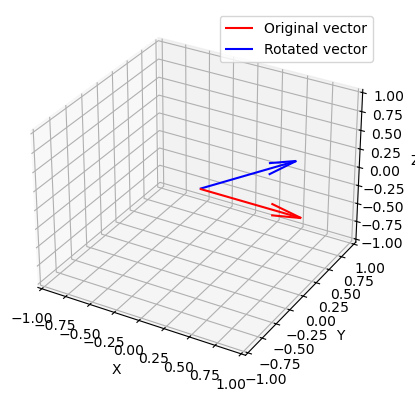

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.transform import Rotation as R

# Define an initial vector
v = np.array([1, 0, 0])

# Create a rotation represented by a quaternion (rotating 60 degrees around the z-axis)
rotation = R.from_quat([0, 0, np.sin(np.pi / 6), np.cos(np.pi / 6)])  # Quaternion (x, y, z, w)

# Apply the rotation to the vector
v_rotated = rotation.apply(v)

# Visualization
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the original vector
ax.quiver(0, 0, 0, v[0], v[1], v[2], color='r', label='Original vector')

# Plot the rotated vector
ax.quiver(0, 0, 0, v_rotated[0], v_rotated[1], v_rotated[2], color='b', label='Rotated vector')

# Set axis limits
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])

# Add legend
ax.legend()

# Set axis labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

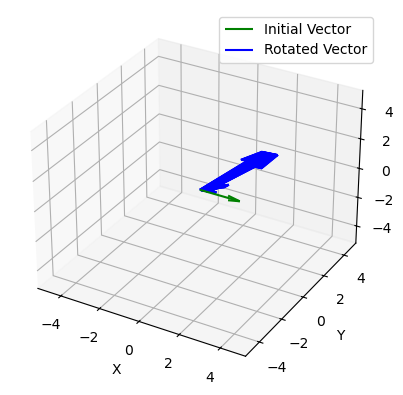

In [134]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from pyquaternion import Quaternion

# Define an initial vector
initial_vector = np.array([2, 0, 0])  # Example initial vector

# Initialize the plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the initial vector
ax.quiver(0, 0, 0, initial_vector[0], initial_vector[1], initial_vector[2], color='g', label='Initial Vector')

# Loop through quaternion data to plot rotated vectors
for i in range(0, Nsim + 1, int((Nsim + 1) / 50)):  # Plot every 50th quaternion for visualization
    quat = Quaternion(X_ref[i, :4, 0])  # Extract the quaternion from the X_ref data
    rot_matrix = quat.rotation_matrix  # Get the rotation matrix from the quaternion
    rotated_vector = rot_matrix @ initial_vector  # Apply the rotation to the initial vector
    
    # Assume position is [0, 0, 0] for simplicity in this example
    position = np.array([0, 0, 0])  
    # Extract the position if available; here, it's set to origin
    position = X_ref[i, 4:, 0]
    rotated_vector = rotated_vector + position
    
    # Plot the rotated vector
    ax.quiver(position[0], position[1], position[2],
              rotated_vector[0], rotated_vector[1], rotated_vector[2],
              color='b', length=1, label='Rotated Vector' if i == 0 else '')

# Set the limits for the axes
lim = 5
ax.set_xlim([-lim, lim])  # Adjusted limits for better visualization
ax.set_ylim([-lim, lim])
ax.set_zlim([-lim, lim])

# ax.autoscale()

# Add a legend to the plot
ax.legend()

# Set axis labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Display the plot
plt.show()


In [ ]:
import numpy as np
from scipy.spatial.transform import Rotation as R
from mayavi import mlab

# Define the origin and initial vector
origin = np.array([0, 0, 0])
vector = np.array([1, 0, 0])

# Create a rotation quaternion representing a 45-degree rotation around the Z-axis
rotation = R.from_euler('z', 45, degrees=True)

# Apply the rotation to the vector
rotated_vector = rotation.apply(vector)

# Create a figure window with background color and size
mlab.figure(bgcolor=(0.1, 0.2, 0.4), size=(800, 600))

# Plot the original vector
mlab.plot3d([origin[0], origin[0] + vector[0]],
            [origin[1], origin[1] + vector[1]],
            [origin[2], origin[2] + vector[2]],
            color=(1, 0, 0), line_width=3.0, tube_radius=0.05, name='Original Vector')

# Plot the rotated vector
mlab.plot3d([origin[0], origin[0] + rotated_vector[0]],
            [origin[1], origin[1] + rotated_vector[1]],
            [origin[2], origin[2] + rotated_vector[2]],
            color=(0, 1, 0), line_width=3.0, tube_radius=0.05, name='Rotated Vector')

# Add axes to the plot
mlab.axes(xlabel='X', ylabel='Y', zlabel='Z')

# Display the figure
mlab.show()


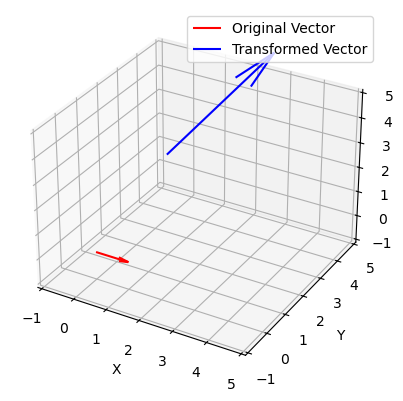

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.transform import Rotation as R

# Define the transformation
translation = np.array([1, 2, 3])
rotation = R.from_euler('z', 45, degrees=True)  # Rotate 45 degrees around Z-axis

# Create vectors
initial_vector = np.array([1, 0, 0])
rotated_vector = rotation.apply(initial_vector)

# Visualization
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot original vector
ax.quiver(0, 0, 0, initial_vector[0], initial_vector[1], initial_vector[2], color='r', label='Original Vector')

# Plot rotated vector
ax.quiver(translation[0], translation[1], translation[2], rotated_vector[0] + translation[0], rotated_vector[1] + translation[1], rotated_vector[2] + translation[2], color='b', label='Transformed Vector')

# Set axis labels and limits
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_xlim([-1, 5])
ax.set_ylim([-1, 5])
ax.set_zlim([-1, 5])
ax.legend()

plt.show()

# SE3 Dynamics Simulation

In [35]:
import jax.numpy as jnp
import numpy as np
from jax import jit
from jax.scipy.linalg import inv
from jax.numpy.linalg import norm
from traoptlibrary.traopt_utilis import coadjoint, skew

@jit
def quat2rotm(quat):
    """ Converts a quaternion to a rotation matrix. """
    q = quat / norm(quat)  # Ensure the quaternion is normalized
    q0, q1, q2, q3 = q

    R = jnp.array([
        [1 - 2 * (q2**2 + q3**2), 2 * (q1*q2 - q0*q3), 2 * (q1*q3 + q0*q2)],
        [2 * (q1*q2 + q0*q3), 1 - 2 * (q1**2 + q3**2), 2 * (q2*q3 - q0*q1)],
        [2 * (q1*q3 - q0*q2), 2 * (q2*q3 + q0*q1), 1 - 2 * (q1**2 + q2**2)]
    ])
    return R

@jit
def SE3Dyn(x, u, i, I):
    # Decompose state vector
    q = x[:4]   # quaternion
    p = x[4:7]  # position
    w = x[7:10] # angular velocity
    v = x[10:13]# linear velocity

    # print(w)

    # Compute Omega matrix for quaternion derivative
    Omega = jnp.array([
        [0, -w[0], -w[1], -w[2]],
        [w[0], 0, w[2], -w[1]],
        [w[1], -w[2], 0, w[0]],
        [w[2], w[1], -w[0], 0]
    ])

    # Quaternion derivative
    dQuat = 0.5 * Omega @ q
    # print(dQuat)

    # Convert quaternion to rotation matrix
    # R_matrix = quat2rotm(q).T  # Transpose for correct orientation
    # quat = Quaternion(jnp.array(q))  # Extract the quaternion from the X_ref data
    # R_matrix = quat.rotation_matrix  # Get the rotation matrix from the quaternion
    R_matrix = quat2rotm(q)

    # Position and velocity derivative
    # print((R_matrix @ v).shape)
    dx = jnp.concatenate((dQuat, R_matrix @ v))
    # print(dx)

    # Compute coadjoint term
    coadj_term = coadjoint(jnp.concatenate((w, v)))

    # Acceleration calculation
    d2x = inv(I) @ (coadj_term @ I @ jnp.concatenate((w, v)) + u)
    # d2x = inv(I) @ (coadj_term @ (I @ jnp.concatenate((w, v))) + u + 0 * I @ jnp.array([0, 0, 0, *(R_matrix.T @ jnp.array([0, 0, -9.81]))]))

    # Return the full state derivative
    dxdt = jnp.concatenate((dx, d2x))

    return dxdt

In [36]:
import math

m = 1
Ib = np.diag([ 0.5,0.7,0.9 ])
J = np.block([
    [Ib, np.zeros((3, 3))],
    [np.zeros((3, 3)), m * np.identity(3)]
])
dt = 0.01

# x = jnp.array([ math.sqrt(2)/2,0,math.sqrt(2)/2,0,0,0,0,
#                 0,0,0,0,0,0 ])
x0 = jnp.array([ 1,0,0,0,0,0,0,
                0,0,0,0,0,0 ])
u = jnp.array([ 0,0,0,0,0,0 ])
i = 1
t1 = x0 + SE3Dyn(x0,u,i,J) * dt
print(t1)
t2 = t1 + SE3Dyn(t1,u,i,J) * dt
print(t2)


[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


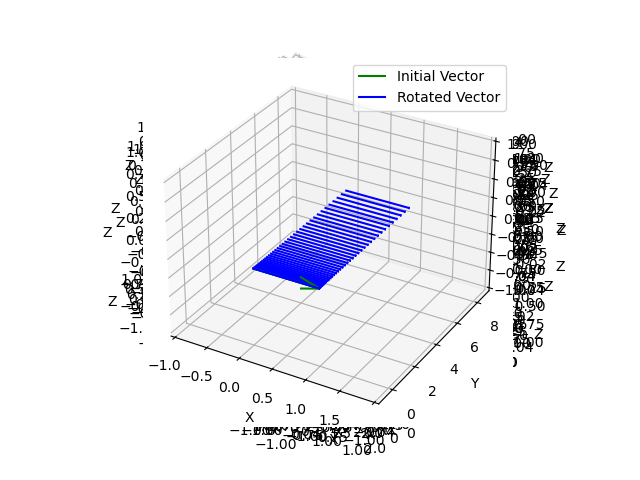

In [55]:
%matplotlib widget

x0 = jnp.array([ 1,0,0,0,0,0,0,
                0,0,0,0,0,0 ])
Nsim = 400
dt = 0.01
x_sim_list = jnp.zeros((Nsim+1, 13))
x_sim_list = x_sim_list.at[0].set( x0 )

m = 1
Ib = np.diag([ 0.5,0.7,0.9 ])
J = np.block([
    [Ib, np.zeros((3, 3))],
    [np.zeros((3, 3)), m * np.identity(3)]
])

u = jnp.array([ 0, 0, 0, 0, 1, 0 ])

for i in range(Nsim):
    x_sim_list = x_sim_list.at[i+1].set( x_sim_list[i] + SE3Dyn(x_sim_list[i],u,i,J) * dt )

from pyquaternion import Quaternion
import matplotlib.pyplot as plt

interval_plot = int((Nsim + 1) / 40)
# interval_plot = 10
# lim = 20

# Initialize the plot
fig1 = plt.figure(1)
ax1 = fig1.add_subplot(111, projection='3d')

# Define an initial vector and plot on figure
initial_vector = np.array([1, 0, 0])  # Example initial vector
ax1.quiver(0, 0, 0, initial_vector[0], initial_vector[1], initial_vector[2], color='g', label='Initial Vector')

positions = []

for i in range(0, Nsim + 1, interval_plot):  

    # quat = Quaternion(x_sim_list[i, :4])  # Extract the quaternion from the X_ref data
    # rot_matrix = quat.rotation_matrix  # Get the rotation matrix from the quaternion

    rot_matrix = quat2rotm(x_sim_list[i, :4])
    rotated_vector = rot_matrix @ initial_vector  # Apply the rotation to the initial vector
    
    # Extract the position 
    position = x_sim_list[i, 4:7]

    # Plot the rotated vector
    ax1.quiver(position[0], position[1], position[2],
              rotated_vector[0], rotated_vector[1], rotated_vector[2],
              color='b', length=1, arrow_length_ratio=0.02, label='Rotated Vector' if i == 0 else '')
    
    positions.append(position)
    positions.append(rotated_vector)

positions = np.array(positions)

# Automatically adjust the axis limits to fit the positions data
if len(positions) > 0:  # Check if positions is not empty
    x_min, x_max = positions[:, 0].min(), positions[:, 0].max()
    y_min, y_max = positions[:, 1].min(), positions[:, 1].max()
    z_min, z_max = positions[:, 2].min(), positions[:, 2].max()

    # Add a small margin to the limits to avoid singular transformation
    margin = 1
    ax1.set_xlim([x_min - margin, x_max + margin])
    ax1.set_ylim([y_min - margin, y_max + margin])
    ax1.set_zlim([z_min - margin, z_max + margin])
else:
    # If positions are empty, set default limits
    ax1.set_xlim([-1, 1])
    ax1.set_ylim([-1, 1])
    ax1.set_zlim([-1, 1])

ax1.legend()
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')

plt.show()


In [53]:
rotated_vector

Array([1.      , 7.979995, 0.      ], dtype=float32)

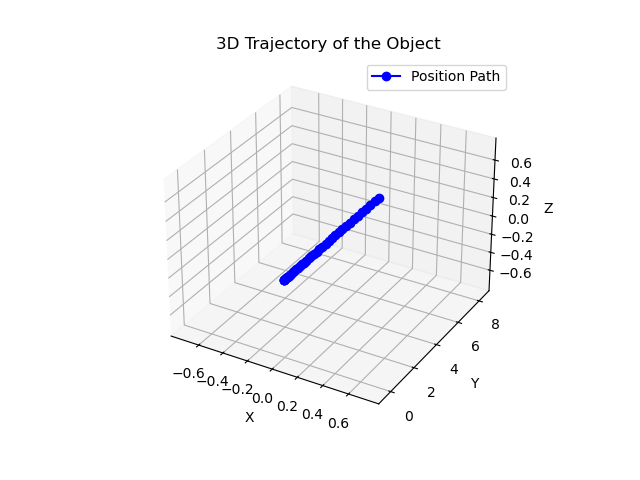

In [51]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Define the initial state vector and simulation data
positions = []

# Simulate and store positions
for i in range(0, Nsim + 1, interval_plot):
    position = x_sim_list[i, 4:7]  # Extract position from the state vector
    positions.append(position)  # Store the position

# Convert list to numpy array for easy slicing
positions = np.array(positions)

# Determine axis limits based on the range of positions
x_min, x_max = positions[:, 0].min(), positions[:, 0].max()
y_min, y_max = positions[:, 1].min(), positions[:, 1].max()
z_min, z_max = positions[:, 2].min(), positions[:, 2].max()

# Add some padding to the limits for better visualization
padding = 0.1 * max(x_max - x_min, y_max - y_min, z_max - z_min)
x_min, x_max = x_min - padding, x_max + padding
y_min, y_max = y_min - padding, y_max + padding
z_min, z_max = z_min - padding, z_max + padding

# Initialize the plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the 3D trajectory
ax.plot(positions[:, 0], positions[:, 1], positions[:, 2], color='blue', marker='o', linestyle='-', label='Position Path')

# Set axis limits based on calculated min and max values
ax.set_xlim([x_min, x_max])
ax.set_ylim([y_min, y_max])
ax.set_zlim([z_min, z_max])

# Set axis labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Add title and legend
ax.set_title('3D Trajectory of the Object')
ax.legend()

# Show the plot
plt.show()

# Error-State DDP

In [3]:
from traoptlibrary.traopt_controller import iLQR
import numpy as np
import jax.numpy as jnp
from jax import random
from traoptlibrary.traopt_dynamics import ErrorStateSE3AutoDiffDynamics
from traoptlibrary.traopt_cost import ErrorStateSE3LieAlgebraAutoDiffQuadraticCost
from traoptlibrary.traopt_utilis import skew, unskew, se3_hat
from scipy.linalg import expm
from pyquaternion import Quaternion
import matplotlib.pyplot as plt

Iteration: 0 , Used Time: 3.840000135824084e-05
iteration 0 accepted 251.52563 1.0 0.5
Iteration: 1 , Used Time: 3.458177918000729
iteration 1 converged 251.52563 0.03234918430760664 0.125


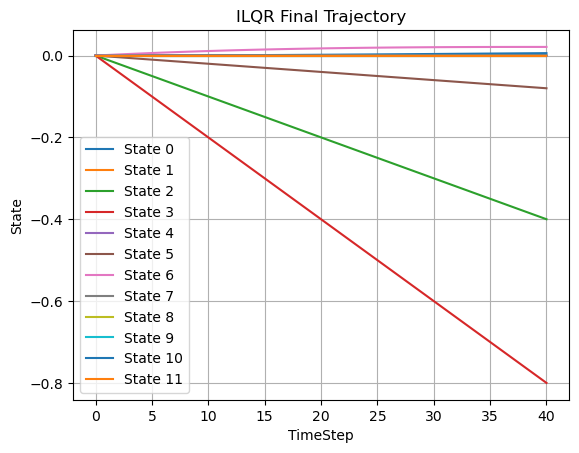

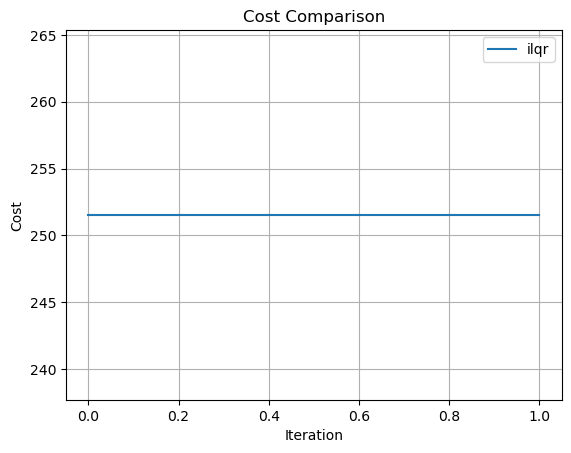

''

In [6]:
def on_iteration(iteration_count, xs, us, J_opt, accepted, converged, alpha, mu, J_hist, xs_hist, us_hist):
    J_hist.append(J_opt)
    xs_hist.append(xs.copy())
    us_hist.append(us.copy())
    info = "converged" if converged else ("accepted" if accepted else "failed")
    # final_state = xs[-1]
    # print("iteration", iteration_count, info, J_opt, "\n", final_state, "\n", alpha, mu)
    print("iteration", iteration_count, info, J_opt, alpha, mu)

seed = 24234156
key = random.key(seed)

dt = 0.01
Nsim = 40   # Simulation horizon

# ====================
# Inertia Matrix
# ====================

m = 1
Ib = np.diag([ 0.5,0.7,0.9 ])
J = np.block([
    [Ib, np.zeros((3, 3))],
    [np.zeros((3, 3)), m * np.identity(3)]
])

    
# =====================================================
# Reference Generation
# =====================================================

# q0_ref = jnp.array([1, 0, 0, 0])
# p0_ref = jnp.array([0, 0, 0])
# w0_ref = jnp.array([0, 0, 1]) * 1
# v0_ref = jnp.array([1, 0, 0.1]) * 2

# # x0_ref and X should be kept the same
# x0_ref = jnp.concatenate((q0_ref, p0_ref))
# # X = np.eye(4) # SE(3)
# X0 = np.block([
#     [ Quaternion(q0_ref).rotation_matrix, p0_ref.reshape(-1,1) ],
#     # [ jnp.array(Quaternion(q0_ref).rotation_matrix), p0_ref.reshape(-1,1) ],
#     [ np.zeros((1,3)),1 ],
# ])
# X = X0.copy()

# xid_ref = jnp.concatenate((w0_ref, v0_ref))

# X_ref = jnp.zeros((Nsim + 1, 7, 1))  # 7 because of [quat(4) + position(3)]
# xi_ref = jnp.zeros((Nsim + 1, 6, 1)) 

# X_ref = X_ref.at[0].set(x0_ref.reshape(7, 1))
# xi_ref = xi_ref.at[0].set(xid_ref.reshape(6, 1))

q0_ref = np.array([1, 0, 0, 0])
p0_ref = np.array([0, 0, 0])
w0_ref = np.array([0, 0, 1]) * 1
v0_ref = np.array([1, 0, 0.1]) * 2

# x0_ref and X should be kept the same
x0_ref = np.concatenate((q0_ref, p0_ref))
# X = np.eye(4) # SE(3)
X0 = np.block([
    [ Quaternion(q0_ref).rotation_matrix, p0_ref.reshape(-1,1) ],
    [ np.zeros((1,3)),1 ],
])
X = X0.copy()

xid_ref = np.concatenate((w0_ref, v0_ref))

X_ref = np.zeros((Nsim + 1, 7, 1))  # 7 because of [quat(4) + position(3)]
xi_ref = np.zeros((Nsim + 1, 6, 1)) 

X_ref[0] = x0_ref.reshape(7,1)
xi_ref[0] = xid_ref.reshape(6,1)

for i in range(Nsim):

    xid_ref_rt = xid_ref.copy()

    # You can try some time-varying twists here:
    # xid_ref_rt[0] = np.sin(i / 20) * 2
    # xid_ref_rt[4] = np.cos(np.sqrt(i)) * 1
    # xid_ref_rt[5] = 1  # np.sin(np.sqrt(i)) * 1

    Xi = np.block([
        [skew(xid_ref_rt[:3]), xid_ref_rt[3:6].reshape(3, 1)],
        [np.zeros((1, 3)), 0]
    ])

    X = X @ expm(Xi * dt)

    # Extract rotation matrix and position vector
    rot_matrix = X[:3, :3]
    position = X[:3, 3]

    # Convert rotation matrix to quaternion
    quaternion = Quaternion(matrix=rot_matrix)
    quat = quaternion.elements

    # Store the reference trajectory (quaternion + position)
    X_ref[i + 1] = np.concatenate((quat, position)).reshape(7,1)
    # X_ref = X_ref.at[i + 1].set(jnp.concatenate((quat, position)).reshape(7,1))

    # Store the reference twists
    xi_ref[i + 1] = xid_ref_rt.reshape(6,1)
    # xi_ref = xi_ref.at[i + 1].set(jnp.concatenate((quat, position)).reshape(7,1))

X_ref = jnp.array(X_ref)
xi_ref = jnp.array(xi_ref)

# =====================================================
# Setup
# =====================================================

N = Nsim
HESSIANS = False
action_size = 6
state_size = 12
debug_dyn = {"vel_zero": False}

# =====================================================
# Dynamics Instantiation
# =====================================================

dynamics = ErrorStateSE3AutoDiffDynamics(J, X_ref, xi_ref, dt, hessians=HESSIANS, debug=debug_dyn)

# =====================================================
# Cost Instantiation
# =====================================================

Q = np.diag([ 
    10., 10., 10., 1., 1., 1.,
    1., 1., 1., 1., 1., 1. 
])
P = np.diag([
    10., 10., 10., 1., 1., 1.,
    1., 1., 1., 1., 1., 1.  
]) * 10
R = np.identity(6) * 1e1

cost = ErrorStateSE3LieAlgebraAutoDiffQuadraticCost( Q, R, P, xi_ref )

# =====================================================
# Solver Instantiation
# =====================================================

x0 = jnp.zeros((state_size,))
us_init = np.zeros((N, action_size,))

ilqr = iLQR(dynamics, cost, N, hessians=HESSIANS)

xs_ilqr, us_ilqr, J_hist_ilqr, xs_hist_ilqr, us_hist_ilqr = \
        ilqr.fit(x0, us_init, n_iterations=200, on_iteration=on_iteration)


# =====================================================
# Visualization by State
# =====================================================

#    plt.figure(1)
#     for j in range( state_size ):
#         plt.plot( xs_ddp[:,j], label = 'State '+str(j) )
#     plt.title('DDP Final Trajectory')
#     plt.xlabel('TimeStep')
#     plt.ylabel('State')
#     plt.legend()
#     plt.grid()

plt.figure(1)
for j in range( state_size ):
    plt.plot( xs_ilqr[:,j], label = 'State '+str(j) )
plt.title('ILQR Final Trajectory')
plt.xlabel('TimeStep')
plt.ylabel('State')
plt.legend()
plt.grid()

plt.figure(2)
plt.plot(J_hist_ilqr, label='ilqr')
# plt.plot(J_hist_ddp, label='ddp')
plt.title('Cost Comparison')
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.legend()
plt.grid()


# =====================================================
# Visualization with Vector
# =====================================================

# interval_plot = int((Nsim + 1) / 40)
# lim = 5

# # Initialize the plot
# fig1 = plt.figure(1)
# ax1 = fig1.add_subplot(121, projection='3d')
# ax2 = fig1.add_subplot(122, projection='3d')

# # Define an initial vector and plot on figure
# initial_vector = np.array([1, 0, 0])  # Example initial vector
# ax1.quiver(0, 0, 0, initial_vector[0], initial_vector[1], initial_vector[2], color='g', label='Initial Vector')
# ax2.quiver(0, 0, 0, initial_vector[0], initial_vector[1], initial_vector[2], color='g', label='Initial Vector')

# # Loop through quaternion data to plot rotated vectors
# for i in range(0, Nsim + 1, interval_plot):  

#     # =========== 1. Plot the reference trajectory ===========

#     quat = Quaternion(X_ref[i, :4, 0])  # Extract the quaternion from the X_ref data
#     rot_matrix = quat.rotation_matrix  # Get the rotation matrix from the quaternion
#     rotated_vector = rot_matrix @ initial_vector  # Apply the rotation to the initial vector
    
#     # Extract the position 
#     position = X_ref[i, 4:, 0]
#     rotated_vector = rotated_vector + position

#     # Plot the rotated vector
#     ax1.quiver(position[0], position[1], position[2],
#               rotated_vector[0], rotated_vector[1], rotated_vector[2],
#               color='b', length=1, label='Rotated Vector' if i == 0 else '')

#     # =========== 2. Plot the simulated velocity ===========
    
#     # se3_matrix = expm( se3_hat( x_sim_list[i, 6:, :] ))
#     # rot_matrix = se3_matrix[:3,:3]  # Get the rotation matrix from the quaternion
#     # rotated_vector = rot_matrix @ initial_vector  # Apply the rotation to the initial vector

#     # position = se3_matrix[:3, 3]
#     # rotated_vector = rotated_vector + position
    
#     # # Plot the rotated vector
#     # ax2.quiver(position[0], position[1], position[2],
#     #           rotated_vector[0], rotated_vector[1], rotated_vector[2],
#     #           color='b', length=1, label='Rotated Vector' if i == 0 else '')
    
#     # =========== 3. Plot the simulated error-state configuration trajectory ===========

#     se3_matrix = np.block([
#         [Quaternion(X_ref[i, :4]).rotation_matrix, X_ref[i, 4:].reshape(3, 1)],
#         [ np.zeros((1,3)), 1 ],
#     ]) @ expm( se3_hat(x_sim_list[i, :6, :]) )
    
#     rot_matrix = se3_matrix[:3,:3]  # Get the rotation matrix from the quaternion
#     rotated_vector = rot_matrix @ initial_vector  # Apply the rotation to the initial vector

#     position = se3_matrix[:3, 3]
#     rotated_vector = rotated_vector + position
    
#     # Plot the rotated vector
#     ax2.quiver(position[0], position[1], position[2],
#               rotated_vector[0], rotated_vector[1], rotated_vector[2],
#               color='b', length=1, label='Rotated Vector' if i == 0 else '')


# # Set the limits for the axes

# ax1.set_xlim([-lim, lim]) 
# ax1.set_ylim([-lim, lim])
# ax1.set_zlim([-lim, lim])
# ax1.legend()
# ax1.set_xlabel('X')
# ax1.set_ylabel('Y')
# ax1.set_zlabel('Z')

# ax2.set_xlim([-lim, lim])  
# ax2.set_ylim([-lim, lim])
# ax2.set_zlim([-lim, lim])
# ax2.legend()
# ax2.set_xlabel('X')
# ax2.set_ylabel('Y')
# ax2.set_zlabel('Z')


# # =====================================================
# # Plotting
# # =====================================================

# Display the plot
plt.show()

In [141]:
plt.figure(1)
for j in range( state_size ):
    plt.plot( xs_ilqr[:,j], label = 'State '+str(j) )
plt.title('ILQR Final Trajectory')
plt.xlabel('TimeStep')
plt.ylabel('State')
plt.legend()
plt.grid()


TypeError: Axes3D.plot() missing 1 required positional argument: 'ys'